In [5]:
import os
import sys
import pathlib
import warnings
import numpy as np
import pandas as pd
from pprint import pprint
import tensorflow as tf
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler
from lips.utils import get_path

In [ ]:
# set some environment variables
sys.path.insert(0, "../../")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

# 1. l2rpn_case14_sandbox grid

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## 1.1 Benchmark1: Risk assessment through contingency screening

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [6]:
topo_actions = benchmark1.config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])

pprint(kwargs_tau)

[(4, (2, 1, 2, 1, 2)), (1, (1, 2, 1, 2, 2, 2)), (5, (1, 1, 2, 2, 1, 2, 2))]


## LeapNet

In this benchmark, we add the topo_vect as input and we inject only the line_status in tau. To do this, go to the benchmark config file, add topo_vect in the input attributes and don't forget to remove it from the tau attributes

In [8]:
leap_net = LeapNet(name="tf_leapnet",                  
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,
                   loss = {"name": "mse"},
                   lr = 1e-4,
                   activation = tf.keras.layers.LeakyReLU(alpha=0.01),
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   layer = "resnet",
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   scaler = PowerGridScaler,
                  )

## Training

In [ ]:
leap_net.train(train_dataset=benchmark1.train_dataset,
               val_dataset=benchmark1.val_dataset,
               batch_size = 128,
               epochs=400)

## Visualization

In [ ]:
tf.keras.utils.plot_model(
    leap_net._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [ ]:
leap_net.summary()

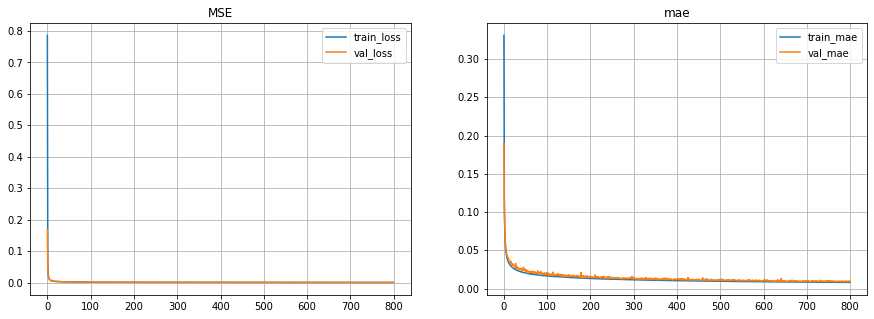

In [11]:
leap_net.visualize_convergence()

## Evaluation

In [ ]:
eval_metrics = benchmark1.evaluate_simulator(augmented_simulator=leap_net,
                                             eval_batch_size=128,
                                             dataset="all",
                                             shuffle=False,
                                             save_predictions=True
                                            )

In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
leap_net.save(SAVE_PATH)

In [14]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", eval_metrics["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))

ML : MAPE90 --> A : mean :0.0026972345519167846, std :2.257382327507931e-05
ML : Inf speed-up : 0.22122633107937872
Rediness : Inf speed-up : 0.23570351500529796
OOD : MAPE90 --> A : mean :0.13378624115772186, std :0.000684655533359696


In [15]:
testset_violoation = [eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

oodset_violoation = [eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))


Physics : test --> CURRENT_POS : mean :0.030901, std :0.0018360000000000008
Physics : ood --> CURRENT_POS : mean :0.028706166666666665, std :0.00043749999999999865
